In [2]:
from statsmodels.graphics.tsaplots import plot_acf
import sys
import numpy as np
sys.path.append('../')
sys.path.append('../rlkit_master/')
from rlkit_master.rlkit.samplers.rollout_functions import rollout
import torch
from gym.envs.mujoco import HalfCheetahEnv
from rlkit_master.rlkit.envs.wrappers import NormalizedBoxEnv
from skimage import util
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle
from math import sqrt

In [3]:
eval_env = NormalizedBoxEnv(HalfCheetahEnv())
exp_name = 'name-of-experiment_2019_11_22_14_30_29_0000--s-0'

In [4]:
def get_action_mean_ft_spectrum_from_epoch(exp_name,act_num,epoch_num):
    agent = torch.load(f'../rlkit_master/data/name-of-experiment/{exp_name}/itr_{epoch_num}.pkl')
    agent = agent['trainer/policy']

    rollout_dict = rollout(
    env = eval_env ,
    agent = agent,
    max_path_length=1000,
    render=False,
    render_kwargs=None,
        )

    M = int(10*8)
    slices = util.view_as_windows(rollout_dict['actions'][:,act_num], window_shape=(M,), step=6)
    # remove DC
    slices -= np.mean(slices)
    
    win = np.hanning(M + 1)[:-1]
    slices = slices * win

    spectrum = np.fft.rfft(slices.T, axis=0, norm="ortho")
    return (np.abs(spectrum).mean(axis = 1))

In [6]:
act_num = 5
x1 = 0
x2 = 41
x = np.arange(x1,x2)

# x = np.linspace(0, 10, 500)
max_steps = 2990
y_dict ={}
for act in range(6):
    for epoch in range(0,max_steps,10):
        y_dict[f'{act}_{epoch}'] = get_action_mean_ft_spectrum_from_epoch(exp_name,act,epoch)
y_dict["y"] = y_dict['0_0']

y_dict['x'] = x

In [7]:

with open(f'y_dict_{exp_name}.ppkl', 'wb') as handle:
    pickle.dump(y_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open(f'y_dict_{exp_name}.ppkl', 'rb') as handle:
    y_dict = pickle.load(handle)

In [6]:
# y_dict.keys()

In [10]:
# Plot aoutocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
epoch_num = 2980#560  2530
act_num = 0#2
# name-of-experiment_2020_01_06_15_38_29_0000--s-0
exp_name = 'name-of-experiment_2019_11_22_14_30_29_0000--s-0'
# 'name-of-experiment_2020_01_10_23_16_20_0000--s-0'
agent = torch.load(f'../rlkit_master/data/name-of-experiment/{exp_name}/itr_{epoch_num}.pkl')
agent = agent['trainer/policy']

rollout_dict = rollout(
env = eval_env ,
agent = agent,
max_path_length=1000,
render=False,
render_kwargs=None,
    )

period = np.argmax(y_dict[f'{act_num}_{epoch_num}'])
actions = rollout_dict['actions'][:,act_num]
period

13

Using matplotlib backend: MacOSX


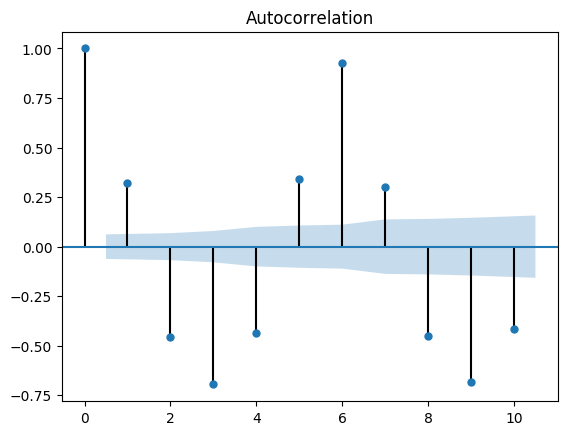

In [14]:
%matplotlib
# plt.xlim = (50,200)

plot_acf(actions,lags=10)

In [20]:
shift = 2
n_start = 650
n_end = 750
plt.figure(figsize=(16, 6))
plt.plot(actions[n_start:n_end])
# plt.plot(actions[13550+13])
plt.plot(actions[n_start+shift:n_end+shift])
plt.show()

In [19]:
# check period
min_rmse = 10
for period in range(1,10):
    rmse = sqrt(mean_squared_error(actions[:-period], actions[period:]))
    print('period =', period )
    print(rmse)
    if rmse < min_rmse:
        min_rmse = rmse
        min_period = period
        
min_period, min_rmse

period = 1
1.0117376612954112
period = 2
1.4851691280089596
period = 3
1.6025759584037236
period = 4
1.4734787806758707
period = 5
0.9986308679201773
period = 6
0.3164522702693344
period = 7
1.0251479088668212
period = 8
1.4837746460176475
period = 9
1.5982071129713284


(6, 0.3164522702693344)